# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper:
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

print(torch.cuda.memory_allocated())

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

0


Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

<a id='section_3'></a>
## Solving Helmholtz equation

Now, solve the Helmholtz Equation

That is, we now seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lambda(\mathbf{x}) \lVert \nabla^2\Phi(\mathbf{x}) +\frac{1}{c(\mathbf{x})^2}\omega^2\Phi(\mathbf{x}) + s(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image and $s(\mathbf{x})$ is a source term.

In [4]:
#!pip install scikit-image
import scipy.ndimage
import skimage.io
import scipy.io

# realpath = "./real.png"
# imagpath = "./imag.png"
# srcpath = "./src.png"
# permrealpath = "./perm_real.png"
# permimagpath = "./perm_imag.png"
matpath = "./siren_data.mat"

def get_img_tensor(sidelength,arr):
    img = Image.fromarray(arr)
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class HelmholtzEqn(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        data = scipy.io.loadmat(matpath)
        img_real = get_img_tensor(sidelength,data['Ereal'])
        img_imag = get_img_tensor(sidelength,data['Eimag'])
        img_src = get_img_tensor(sidelength,data['S'])
        img_perm_real = get_img_tensor(sidelength,data['eps_real'])
        img_perm_imag = get_img_tensor(sidelength,data['eps_imag'])

        # Compute gradient and laplacian
        grads_x_real = scipy.ndimage.sobel(img_real.numpy(), axis=1).squeeze(0)[..., None]
        grads_y_real = scipy.ndimage.sobel(img_real.numpy(), axis=2).squeeze(0)[..., None]
        grads_x_real, grads_y_real = torch.from_numpy(grads_x_real), torch.from_numpy(grads_y_real)

        grads_x_imag = scipy.ndimage.sobel(img_imag.numpy(), axis=1).squeeze(0)[..., None]
        grads_y_imag = scipy.ndimage.sobel(img_imag.numpy(), axis=2).squeeze(0)[..., None]
        grads_x_imag, grads_y_imag = torch.from_numpy(grads_x_imag), torch.from_numpy(grads_y_imag)

        self.grads_real = torch.stack((grads_x_real, grads_y_real), dim=-1).view(-1, 2)
        self.laplace_real = scipy.ndimage.laplace(img_real.numpy()).squeeze(0)[..., None]
        self.laplace_real = torch.from_numpy(self.laplace_real)

        self.grads_imag = torch.stack((grads_x_imag, grads_y_imag), dim=-1).view(-1, 2)
        self.laplace_imag = scipy.ndimage.laplace(img_imag.numpy()).squeeze(0)[..., None]
        self.laplace_imag = torch.from_numpy(self.laplace_imag)

        self.pixels_real = img_real.permute(1, 2, 0).view(-1, 1)
        self.pixels_imag = img_imag.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

        self.pixels_src = img_src.permute(1, 2, 0).view(-1, 1)
        self.pixels_perm_real = img_perm_real.permute(1, 2, 0).view(-1, 1)
        self.pixels_perm_imag = img_perm_imag.permute(1, 2, 0).view(-1, 1)        

    def __len__(self):
        return self.coords.shape[0]   # number of pixels

    def __getitem__(self, idx):
        return (self.coords[idx],
                self.pixels_real[idx],
                self.pixels_imag[idx],
                self.pixels_src[idx],
                self.pixels_perm_real[idx],
                self.pixels_perm_imag[idx])

#### Instantiate SIREN model

In [11]:
helmholtz_obj = HelmholtzEqn(382)

helmholtz_siren = Siren(in_features=2, out_features=2, hidden_features=256,
                      hidden_layers=4, outermost_linear=True)
helmholtz_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): Linear(in_features=256, out_features=2, bias=True)
  )
)

#### Define the loss function

In [12]:
def helmholtz_mse(model_pred_real, model_pred_imag, coords, perm_real, perm_imag, src, omega, k):
    # weighting
    lam = torch.where(src < 0, k, 1.0)
    
    # compute gradients on the model
    laplace_pred_real = laplace(model_pred_real, coords)
    laplace_pred_imag = laplace(model_pred_imag, coords)

    # compute residuals
    omegasqr = omega*omega
    real_loss = laplace_pred_real + perm_real*omegasqr*model_pred_real - \
                perm_imag*omegasqr*model_pred_imag
    imag_loss = laplace_pred_imag + perm_real*omegasqr*model_pred_imag + \
                perm_imag*omegasqr*model_pred_real + src

    # scale total loss by weighting factor
    total_loss = (lam*(torch.abs(real_loss) + torch.abs(imag_loss))).mean()  # Changed from .sum(-1) to .mean()
    
    return total_loss

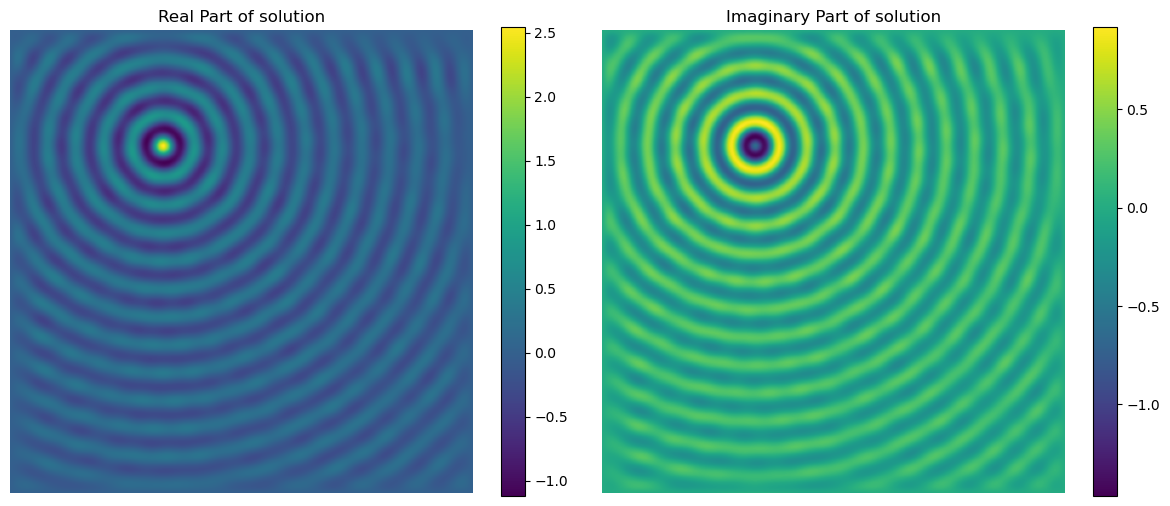

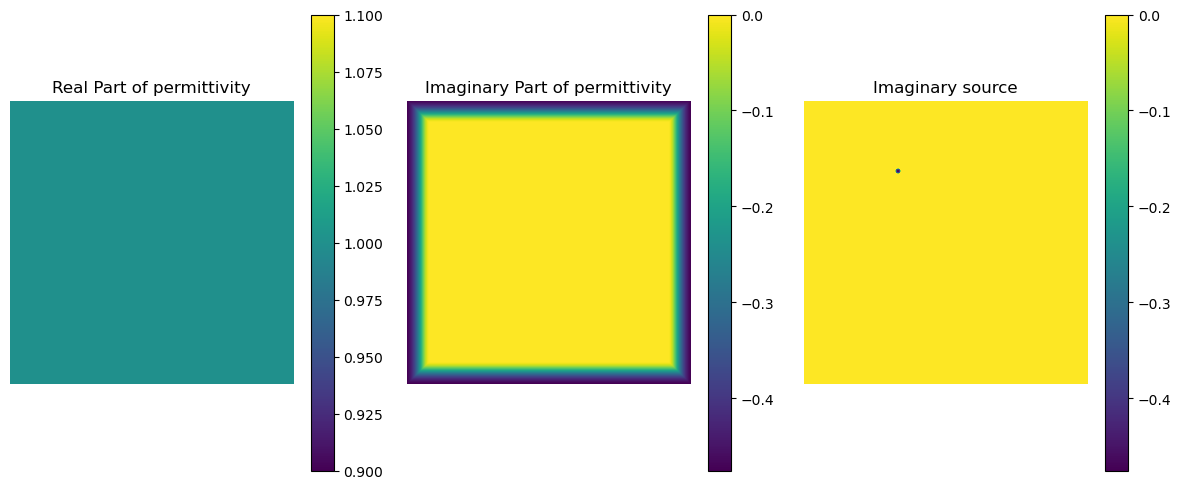

In [14]:
import scipy.io as io

mat_data = io.loadmat('siren_data.mat')

import matplotlib.pyplot as plt

# Create the plot of solved Helmholtz using grid solver
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(mat_data['Ereal'], cmap='viridis')
axes[0].set_title('Real Part of solution')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mat_data['Eimag'], cmap='viridis')
axes[1].set_title('Imaginary Part of solution')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Create the plot of input parameters
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

im0 = axes[0].imshow(mat_data['eps_real'], cmap='viridis')
axes[0].set_title('Real Part of permittivity')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mat_data['eps_imag'], cmap='viridis')
axes[1].set_title('Imaginary Part of permittivity')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(mat_data['S'], cmap='viridis')
axes[2].set_title('Imaginary source')
axes[2].axis('off')
plt.colorbar(im1, ax=axes[2])

plt.tight_layout()
plt.show()

#### Train the model

22808064
Step 0, Total loss 0.064845, iteration time 5.651418
Checkpoint saved at step 0


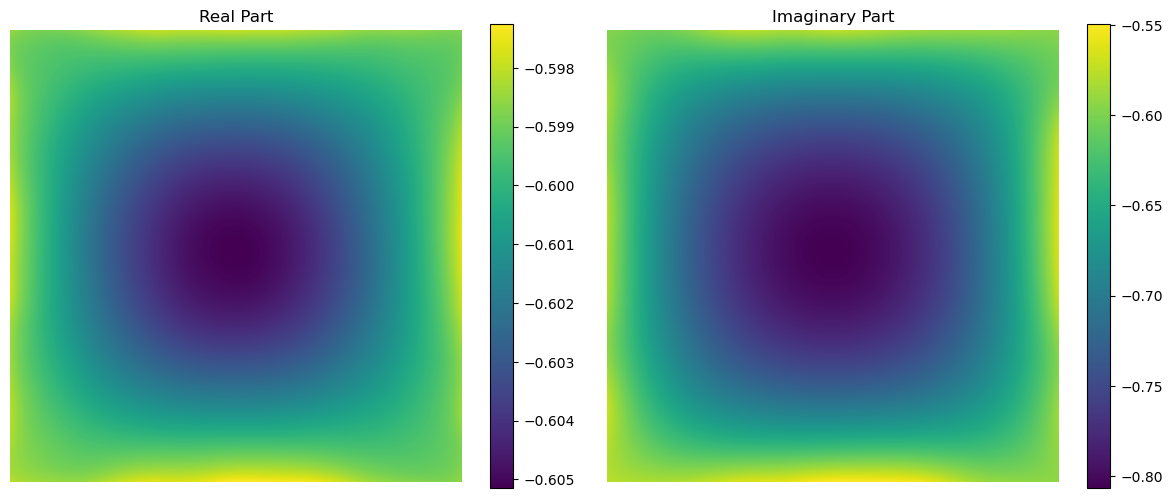

KeyboardInterrupt: 

In [9]:
import os

# Create a directory to save checkpoints
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)

dataloader = DataLoader(helmholtz_obj, batch_size=4096, shuffle=True)

total_steps = 1000
steps_til_summary = 10
steps_til_disp = 100

omega = 0.4
k = 0.8

optim = torch.optim.Adam(lr=2e-5, params=helmholtz_siren.parameters())
print(torch.cuda.memory_allocated())

for step in range(total_steps):
    start_time = time.time()
    
    helmholtz_siren.train()
    total_loss = 0.0
    total_samples = 0
    
    for coords, ereal, eimag, src, epsr, epsi in dataloader:
        coords = coords.cuda()
        src = src.cuda()
        epsr = epsr.cuda()
        epsi = epsi.cuda()
        
        pred, coords = helmholtz_siren(coords)
        loss = helmholtz_mse(pred[:,0:1], pred[:,1:2], coords, epsr, epsi, src, omega, k)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        total_loss += loss.item() * coords.shape[0]
        total_samples += coords.shape[0]
    
    if not step % steps_til_summary:
        avg_loss = total_loss / total_samples
        print("Step %d, Total loss %0.6f, iteration time %0.6f" % (step, avg_loss, time.time() - start_time))

    if not step % steps_til_disp:
        # save the current model checkpoint
        checkpoint_path = os.path.join(save_dir, f'model_step_{step}.pth')
        torch.save({
            'step': step,
            'model_state_dict': helmholtz_siren.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Checkpoint saved at step {step}")
        
        # Visualize the current model output
        helmholtz_siren.eval()
        with torch.no_grad():
            # Get the full coordinate grid
            full_coords = helmholtz_obj.coords.cuda()
            full_pred, _ = helmholtz_siren(full_coords)
            
            # Extract real and imaginary parts and reshape to 382x382
            pred_real = full_pred[:, 0].cpu().numpy().reshape(382, 382)
            pred_imag = full_pred[:, 1].cpu().numpy().reshape(382, 382)
            
            # Create the plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            im0 = axes[0].imshow(pred_real, cmap='viridis')
            axes[0].set_title('Real Part')
            axes[0].axis('off')
            plt.colorbar(im0, ax=axes[0])
            
            im1 = axes[1].imshow(pred_imag, cmap='viridis')
            axes[1].set_title('Imaginary Part')
            axes[1].axis('off')
            plt.colorbar(im1, ax=axes[1])
            
            plt.tight_layout()
            plt.show()
        
        helmholtz_siren.train()